# 0. About

This notebook is to try to use some supervised PCA.
Currently there is no supervised PCA module in sklearn, so we need to modify the module a little.

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

rs_num = 42

In [2]:
# load data
X, y = load_diabetes(return_X_y=True)
sample_num, feature_num = X.shape

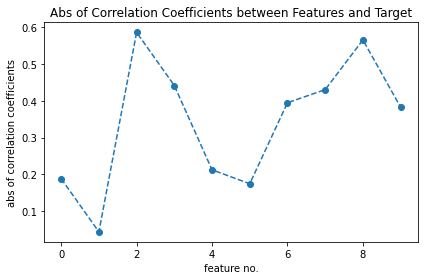

In [3]:
# check dataset correlation coefficients between features and target
corr_coef = np.corrcoef(X.T, y.T)

fig, ax = plt.subplots()

ax.plot(np.abs(corr_coef[:-1, -1]), ls='--', marker='o')
ax.set_xlabel('feature no.')
ax.set_ylabel('abs of correlation coefficients')
ax.set_title('Abs of Correlation Coefficients between Features and Target')

plt.tight_layout()

# 1. Data/Pipeline Setup

We can prepare some classes for the PCA and GPR.
In general, we wish to see how the following variables can change the model prediction:
1. if we apply data standardization transformation
2. if we pre-screen the data with supervised PCA
3. if we change the threshold $\theta$ of the supervised PCA (using GPR 5-fold cross-validation)
4. if we change the threshold of the PCA scree plot after the above pre-processing steps. 

As the evaluation metric, we can use the **5-fold cross-validation scores** from sklearn Gaussian Process Regression (GPR). 
Of course to prevent leaking data into the model, we should split the dataset into **Training Data** and **Test Data**, and apply k-fold cross-validation directly on the **Training Data**, i.e. when calculating mean/std/etc, we only calculate the **Training Data**, as is indicated here: [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

## 1.1. Split Data into Training and Test

In [23]:
[X_train, 
 X_test, 
 y_train, 
 y_test] = train_test_split(X, y, test_size=0.20, random_state=rs_num)
X_train.shape

(353, 10)

## 1.2. Construct Pipelines

In [30]:
test_kernel = ConstantKernel(constant_value=1)*RBF(length_scale=np.ones((1, )))

test_pipeline = Pipeline(
    [('scaler', StandardScaler()), 
     ('PCA', PCA(n_components=1, random_state=rs_num)), 
     ('GPR', GaussianProcessRegressor(
         kernel=test_kernel, 
         n_restarts_optimizer=9, 
         random_state=rs_num))]
)
test_pipeline.fit(X_train, y_train)
cross_validate(test_pipeline, X_train, y_train, cv=5)

C:\Users\Chao\anaconda3\envs\CAP_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


{'fit_time': array([1.39136624, 1.47268081, 1.43260884, 1.9984715 , 1.67614412]),
 'score_time': array([0.00199533, 0.00099778, 0.00199461, 0.00199485, 0.00199485]),
 'test_score': array([-4.29362031, -4.32589622, -4.28000634, -3.000152  , -3.97323159])}

In [31]:
test_pipeline.score(X_test, y_test)

-4.008093176354173

# 1. Regular PCA

First we need to make a benchmark to see how it goes with the dataset with the regular PCA.

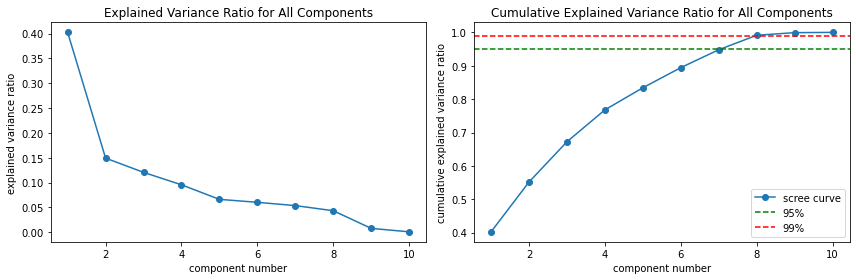

In [11]:
regular_pca = PCA(random_state=22)
regular_pca.fit(X)

# compute cumulative explained variance ratio
regular_cu_evr = np.zeros_like(regular_pca.explained_variance_ratio_)
for i in range(regular_pca.n_components_):
    regular_cu_evr[i] = regular_pca.explained_variance_ratio_[:i+1].sum()

# visualize explained variance and variance ratio
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(
    np.arange(1, regular_pca.n_components_+1, 1), 
    regular_pca.explained_variance_ratio_, '-o'
)
axes[0].set_xlabel('component number')
axes[0].set_ylabel('explained variance ratio')
axes[0].set_title('Explained Variance Ratio for All Components')

axes[1].plot(
    np.arange(1, regular_pca.n_components_+1, 1), 
    regular_cu_evr, '-o', label='scree curve'
)
axes[1].axhline(y=0.95, color='green', ls='--', label='95%')
axes[1].axhline(y=0.99, color='red', ls='--', label='99%')
axes[1].set_xlabel('component number')
axes[1].set_ylabel('cumulative explained variance ratio')
axes[1].set_title('Cumulative Explained Variance Ratio for All Components')
axes[1].legend()

plt.tight_layout()

We can also check each feature contribution of the first component.

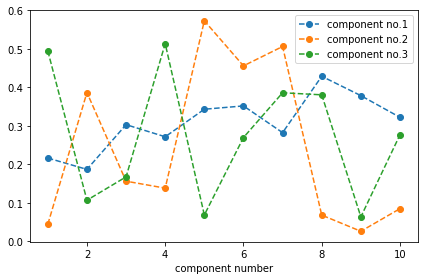

In [20]:
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(
        np.arange(1, regular_pca.n_components_+1, 1), 
        np.abs(regular_pca.components_[i, :]), 
        ls='--', marker='o', label='component no.{:}'.format(i+1)
    )
ax.set_xlabel('component number')
ax.legend()
plt.tight_layout()

# 2. Bair's Supervised Principal Components

The algorithm is documented in the following paper:
[Prediction by Supervised Principal Components](https://doi.org/10.1198/016214505000000628).

The idea is to compute the [**Standard Regression Coefficients**](https://en.wikipedia.org/wiki/Standardized_coefficient) between X and y first, and ignore fetures with low coefficients.

In [4]:
# compute standardized regression coefficients
beta_weights = np.zeros((feature_num, 1))
for feature_i in range(feature_num):
    beta_weights[feature_i, 0] = X[:, feature_i].dot(y.flatten())/np.linalg.norm(X[:, feature_i])

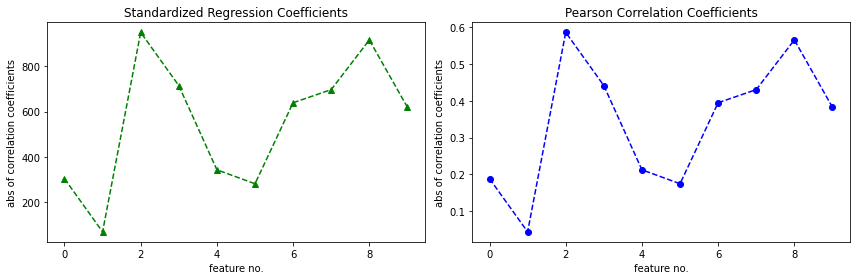

In [5]:
# visualize the coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Standardized Regression Coefficients
axes[0].plot(np.abs(beta_weights), marker='^', ls='--', color='green')
axes[0].set_xlabel('feature no.')
axes[0].set_ylabel('abs of correlation coefficients')
axes[0].set_title('Standardized Regression Coefficients')

# Pearson Correlation Coefficients
axes[1].plot(np.abs(corr_coef[:-1, -1]), ls='--', marker='o', color='blue')
axes[1].set_xlabel('feature no.')
axes[1].set_ylabel('abs of correlation coefficients')
axes[1].set_title('Pearson Correlation Coefficients')

plt.tight_layout()